In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Feature Selection

In [11]:
sheets = ['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']
dataframes  = {sheet: pd.read_excel('/content/drive/MyDrive/final pj msoft/E-commerce_data.xlsx', sheet_name=sheet ) for sheet in sheets}

# Merge oll datoframes into one

merged_df  = dataframes['customers']
for sheet in sheets[1:]:
   if sheet == 'genders':
      merged_df = pd.merge(merged_df, dataframes[sheet], on='gender_id', how='left')
   elif sheet == 'cities':
       merged_df = pd.merge(merged_df, dataframes[sheet], on='city_id', how='left')
   elif sheet == 'transactions':
       merged_df = pd.merge(merged_df, dataframes[sheet], on='customer_id', how='left')
   elif sheet == 'branches':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='branch_id', how='left')
   elif sheet == 'merchants':
       merged_df = pd.merge(merged_df, dataframes[sheet], on='merchant_id', how='left')



In [12]:
merged_df

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,2022-01-08,7,1,Male,Mansoura,178.0,2022-07-30,subscribed,SrP-866,NaT,8.0,20.0,Griffin-Leblanc
1,1,2022-01-08,7,1,Male,Mansoura,257.0,2022-09-19,burned,krI-075,2022-11-05,1.0,11.0,"Smith, Lawson and Hernandez"
2,1,2022-01-08,7,1,Male,Mansoura,1652.0,2022-06-09,burned,quk-137,2022-07-19,6.0,15.0,Butler-Gomez
3,1,2022-01-08,7,1,Male,Mansoura,1929.0,2022-07-30,burned,QiG-754,2022-10-18,8.0,20.0,Griffin-Leblanc
4,1,2022-01-08,7,1,Male,Mansoura,2352.0,2023-03-24,subscribed,OtC-985,NaT,4.0,15.0,Butler-Gomez
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,999,2022-07-16,6,1,Male,Suez,541.0,2023-05-18,burned,rqU-020,2023-07-15,8.0,20.0,Griffin-Leblanc
5007,999,2022-07-16,6,1,Male,Suez,2216.0,2022-12-21,burned,VoR-120,2023-02-17,2.0,18.0,Lewis LLC
5008,999,2022-07-16,6,1,Male,Suez,3996.0,2024-04-09,burned,vGo-341,2024-05-07,3.0,8.0,Medina-Foster
5009,1000,2024-04-08,2,2,Female,Alexandria,1159.0,2024-04-20,subscribed,TmE-861,NaT,8.0,20.0,Griffin-Leblanc


In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['gender_name'] = label_encoder.fit_transform(merged_df['gender_name'])
merged_df['city_name'] = label_encoder.fit_transform(merged_df['city_name'])

# Feature engineering - create more useful transactional features
# Frequency of transactions per customer
merged_df['transaction_count'] = merged_df.groupby('customer_id')['transaction_id'].transform('count')

# Number of burnt coupons per customer
merged_df['burnt_coupons'] = merged_df[merged_df['transaction_status'] == 'burned'].groupby('customer_id')['transaction_id'].transform('count')

# Drop duplicate records to avoid inflating counts (keeping one record per customer)
customer_features = merged_df.drop_duplicates(subset='customer_id')
# Fill missing burnt coupons count with 0 for customers who haven't burnt any coupons
merged_df['burnt_coupons'] = merged_df['burnt_coupons'].fillna(0)

merged_df['last_transaction_date'] = pd.to_datetime(merged_df.groupby('customer_id')['transaction_date'].transform('max'))

merged_df['first_transaction_date'] = pd.to_datetime(merged_df.groupby('customer_id')['transaction_date'].transform('min'))

# Drop duplicate records to avoid inflating counts (keeping one record per customer)
customer_features = merged_df.drop_duplicates(subset='customer_id')

# Select relevant columns for clustering
X = customer_features[['transaction_count', 'burnt_coupons',
                       'gender_name', 'city_name']]


In [14]:
X

,transaction_count,burnt_coupons,gender_name,city_name
0,7,0.0,1,11
7,3,0.0,0,16
10,5,0.0,1,1
15,1,0.0,0,10
16,4,3.0,1,7
...,...,...,...,...
4995,3,0.0,1,9
4998,3,0.0,0,16
5001,4,3.0,0,10
5005,4,4.0,1,17


# Model Development (K-Means)

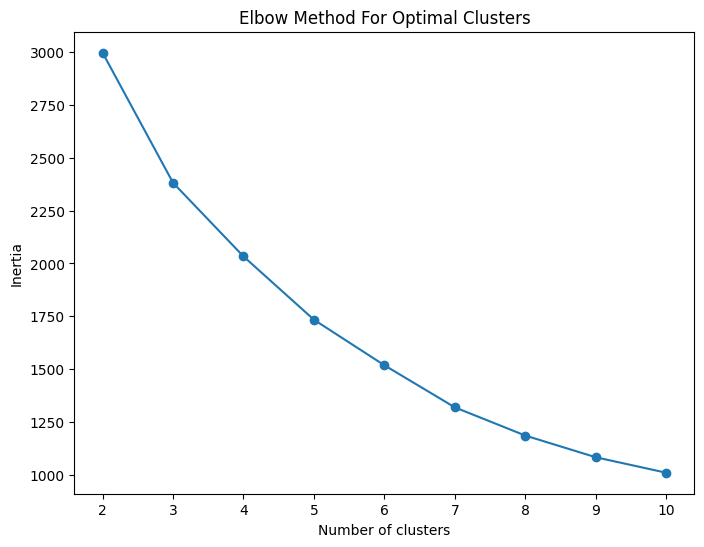

Silhouette Score: 0.2720627618035006


<ipython-input-15-f0f396264d74>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features['cluster'] = kmeans.labels_


In [15]:

# Scale the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to plot inertia to find the optimal number of clusters
def plot_elbow_method(X_scaled):
    inertia = []
    for n in range(2, 11):  # Testing between 2 to 10 clusters
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title('Elbow Method For Optimal Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Plot the elbow method
plot_elbow_method(X_scaled)

# Based on elbow plot, assume optimal clusters are 4 (or any number observed)
try:
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Assign cluster labels to the dataset
    customer_features['cluster'] = kmeans.labels_

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    print(f'Silhouette Score: {silhouette_avg}')
except Exception as e:
    print(f"Error in KMeans clustering or silhouette score calculation: {str(e)}")


# Model Evaluation

In [17]:
# Calculate the silhouette score
silhouette_avg = silhouette_score(X_scaled, customer_features['cluster'])
print(f'Silhouette Score for the model: {silhouette_avg}')



Silhouette Score for the model: 0.2720627618035006


# Segment Analysis

   cluster  transaction_count  burnt_coupons
0        0           4.387255       1.151961
1        1           4.711111       1.071111
2        2           4.490000       0.660000
3        3           7.304094       4.485380


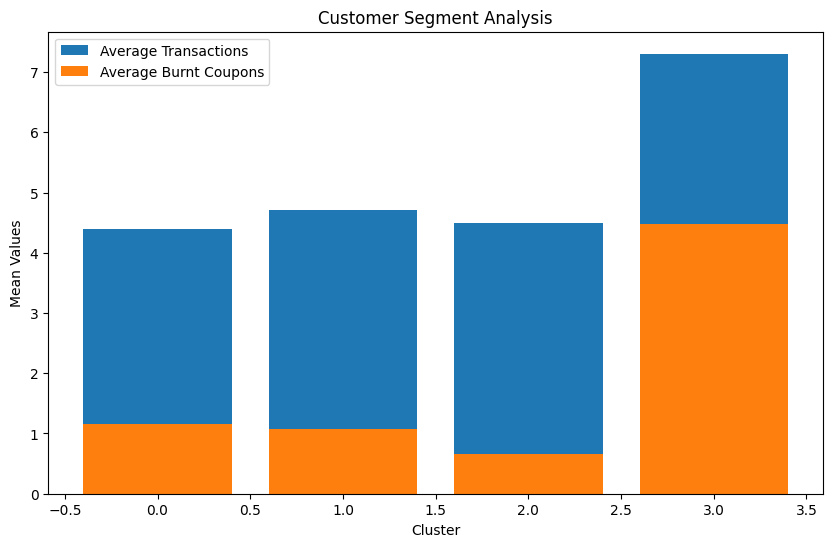

In [18]:
# Analyze each segment
cluster_summary = customer_features.groupby('cluster').agg({
    'transaction_count': 'mean',
    'burnt_coupons': 'mean',
    # Check if these columns exist before trying to aggregate them.
    # You can print(customer_features.columns) to list all available columns.
    # Replace 'gender_name_male', 'city_name_CityA' if necessary
    **{col: 'mean' for col in customer_features.columns if col in ['gender_name_male', 'city_name_CityA']}
}).reset_index()

print(cluster_summary)

# Visualizing the clusters
plt.figure(figsize=(10,6))
plt.bar(cluster_summary['cluster'], cluster_summary['transaction_count'], label='Average Transactions')
plt.bar(cluster_summary['cluster'], cluster_summary['burnt_coupons'], label='Average Burnt Coupons')
plt.legend()
plt.title('Customer Segment Analysis')
plt.xlabel('Cluster')
plt.ylabel('Mean Values')
plt.show()